## HAR EVALUATION

In this notebook, you can see the results we got with the HAR dataset. We used the top 144 features that have the most variance (meaning the features that change the most among the six labels). The notebook has two main parts. The first part talks about the functions we used. After that, we will evaluate each model using the micro F1 score.

In [1]:
import json
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import f1_score
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.manifold import TSNE
"""
NOTE: import the HAR.py and datasets files in the same folder of this notebook
        |
        |
        V
"""
from HAR import *
path = r"HAR_dataset.csv"
path_test = r"HAR_dataset_test.csv"
    
    
seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"

# train clients used for HAR
clients = [1, 3, 5, 6, 7, 8, 11, 14, 15, 16, 17, 19, 21, 22, 23, 25, 26, 27, 28, 29, 30]

# test clients
clients_test = [2, 4, 9, 10, 12, 13, 18, 20, 24]

classes = 6
image_shape = (12,12) # the 144 features have been seen as an image 12x12

# load the HAR object
har = HAR(path)
har_test = HAR(path_test)

In [86]:
"""
scope --> plot the history of the model
    rounds: number of epochs;
    train_loss: a list with all the train loss along the epochs;
    val_loss: as train loss, with validation loss;
    num_clients: a list that describes the number of clients in each epochs;
    model_name: a tring contains the model name.
"""
def plot_history(rounds, train_loss, val_loss, num_clients, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(rounds, train_loss, label='Train Loss', color='blue')
    plt.plot(rounds, val_loss, label='Validation Loss', color='orange')
    plt.xlabel('Rounds')
    plt.ylabel('Loss')
    plt.title('Training, Validation Loss and N. Clients Over Rounds for {0}'.format(model_name))
    plt.legend(loc='upper right')
    ax2 = plt.gca().twinx()
    ax2.plot(rounds, num_clients, label='Number of Clients', color='green', linestyle='dashed', alpha=0.5)
    ax2.set_ylabel('Number of Clients')
    plt.grid(True)
    plt.show()
    
"""
scope --> plot the 3D Latent Space of the CI-VAE
    data: the array with the x samples for the Encoder;
    labels: the array with the labels for the x samples.
"""
def plot_label_clusters_3d(data, labels):
    _, _, z = CI_VAE.get_layer('encoder').predict(data)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=labels)
    plt.colorbar(scatter, ticks=range(len(set(labels)) + 1))
    ax.set_xlabel("z[0]")
    ax.set_ylabel("z[1]")
    ax.set_zlabel("z[2]")
    plt.show()
    
"""
scope --> plot the sample and its label (if provided, also the probability of the label)
    images: the array for the x samples;
    labels_per_images: the labels of the x samples;
    title: the string for the title of the Figure;
    n_rows and images_per_line: how many samples plot in each row and how many rows to plot;
    probs: if the array is provided, then the probability of the label is also printed
"""
def plot_images(images, labels_per_images, title, n_rows=2, images_per_line=10, probs=None):
    predicts = [np.array(pred) for pred in images[:n_rows*images_per_line]]
    num_images = len(predicts)
    total_lines = min(n_rows, (num_images - 1) // images_per_line + 1)
    fig, axes = plt.subplots(total_lines, images_per_line, figsize=(15, 5))
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.suptitle(title)
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            image_data = predicts[i].reshape(12, 12)
            ax.imshow(image_data, cmap='viridis')
            ax.axis('off') 
            if probs is None: ax.set_title(labels_per_images[i])
            else: 
                prob = round(probs[i], 2)
                ax.set_title("{0} with prob: {1:.2f}".format(labels_per_images[i], prob), fontsize=9)
        else:
            fig.delaxes(ax)
    plt.show()
    
"""
scope: computing the loss for the standard Classifier (Local CL and Fed CL)
"""
def compute_loss_CH(x, y, training=True):
    class_loss = CH_model(x, training=training)
    class_loss = tf.reduce_mean(keras.losses.categorical_crossentropy(y, class_loss))
    return class_loss

"""
scope: computing the loss for the CI-VAE (Fed CI-VAE, FedRep CI-VAE)
"""
def compute_loss(x, y, training=True):
    z_mean, z_log_var, z = CI_VAE.get_layer('encoder')(x, training=training)
    reconstruction = CI_VAE.get_layer('decoder')(z, training=training)
    mae_loss = tf.reduce_mean(keras.losses.mean_squared_error(x, reconstruction))
    mae_loss *= image_shape[0] * image_shape[1]
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss *= -0.5
    class_loss = CI_VAE.get_layer('class_model')(z, training=training)
    class_loss = tf.reduce_mean(keras.losses.categorical_crossentropy(y, class_loss))
    return mae_loss, kl_loss, class_loss

"""
scope: training the standard Classifier (Local CL and Fed CL)
NOTE: LR, batch, early stopping and epochs have been already tuned for this dataset
"""
def train_CH(epochs=51):
    learning_rate = 0.001
    batch = 8
    optimizer = Adam(learning_rate=learning_rate)
    CH_model.compile(optimizer=optimizer)
    previous_loss = float('inf')
    early_stopping = 3
    count = 0
    for _ in range(epochs):
        for batch_data in range(len(train_labels)//batch):
            y = train_labels[batch_data*batch:batch_data*batch+batch]
            x = train_images[batch_data*batch:batch_data*batch+batch]
            if x.shape[0] == 0: continue
            with tf.GradientTape() as tape:
                total_loss = compute_loss_CH(x, y)
            grads = tape.gradient(total_loss, CH_model.trainable_weights)
            optimizer.apply_gradients(zip(grads, CH_model.trainable_weights))
        actual_loss = compute_loss_CH(train_images, train_labels, training=False)
        if actual_loss > previous_loss: 
            count += 1
            if count == early_stopping: break
        else: 
            previous_loss = actual_loss
            count = 0
    return  
    
"""
scope: training the standard Classifier with only few-shots
"""
def train_CH_shots(steps=51, shots=2):
    learning_rate = 0.001
    batch = 8
    optimizer = Adam(learning_rate=learning_rate)
    CH_model.compile(optimizer=optimizer)
    classes_choosen = classes
    if len(list(set(train_labels.argmax(1)))) < classes_choosen: classes_choosen = len(list(set(train_labels.argmax(1))))
    x_val, y_val = GetMiniDatasetTest(train_images, train_labels.argmax(1), classes_choosen=classes_choosen,
                                      shots_per_class=shots)  
    test_classes_used = list(set(list(y_val)))
    y_val = convert_to_categorical(y_val, classes)
    previous_loss = float('inf')
    early_stopping = 3
    count = 0
    for _ in range(steps):
        with tf.GradientTape() as tape:
            total_loss = compute_loss_CH(x_val, y_val)
        grads = tape.gradient(total_loss, CH_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, CH_model.trainable_weights))
        actual_loss = compute_loss_CH(train_images, train_labels, training=False)
        if actual_loss > previous_loss: 
            count += 1
            if count == early_stopping: break
        else: 
            previous_loss = actual_loss
            count = 0
    return 
 
"""
scope: training the CI-VAE with only few-shots
"""
def train_shots(steps=1001, shots=2):
    learning_rate = 0.001
    batch = 8
    optimizer = Adam(learning_rate=learning_rate)
    CI_VAE.compile(optimizer=optimizer)
    CI_VAE.get_layer("class_model").trainable=False
    classes_choosen = classes
    if len(list(set(train_labels.argmax(1)))) < classes_choosen: classes_choosen = len(list(set(train_labels.argmax(1))))
    x_val, y_val = GetMiniDatasetTest(train_images, train_labels.argmax(1), classes_choosen=classes_choosen,
                                      shots_per_class=shots)  
    test_classes_used = list(set(list(y_val)))
    y_val = convert_to_categorical(y_val, classes)
    previous_loss = float('inf')
    early_stopping = 10
    count = 0
    for _ in range(steps):
        with tf.GradientTape() as tape:
            total_loss = compute_loss(x_val, y_val)
        grads = tape.gradient(total_loss, CI_VAE.trainable_weights)
        optimizer.apply_gradients(zip(grads, CI_VAE.trainable_weights))
        mse, kl, class_l = compute_loss(train_images, train_labels, training=False)
        actual_loss = mse + kl + class_l
        if actual_loss > previous_loss: 
            count += 1
            if count == early_stopping: break
        else: 
            previous_loss = actual_loss
            count = 0
    return 

## Local CL

In [23]:
har.create_model_CH(dense_size=128).summary()

Model: "CH"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 12, 12, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 144)               0         
                                                                 
 1_Dense (Dense)             (None, 128)               18560     
                                                                 
 2_Dense (Dense)             (None, 64)                8256      
                                                                 
 Output_Layer (Dense)        (None, 6)                 390       
                                                                 
Total params: 27,206
Trainable params: 27,206
Non-trainable params: 0
_________________________________________________________________


In [27]:
f1s = []
for i in range(len(clients)):
    # load the client dataset and apply preprocessing 
    # (MinMaxScaler and get only the first 144 features with the highest variance)
    client = clients[i]
    dataset = har.get_dataset(client)
    CH_model = har.create_model_CH(dense_size=128)
    train_images, train_labels, test_images, test_labels = dataset
    train_images, test_images = har.preprocessing(train_images, test_images)
    
    # train the model locally and test it
    train_CH(epochs=51)
    predicts = CH_model.predict(test_images, batch_size=128, verbose=0)
    f1 = f1_score(test_labels.argmax(1), predicts.argmax(1), average='micro')
    f1s.append(f1)
    print("Client: {0}, n. samples: {1}, micro f1: {2}".format(client, len(train_images), round(f1,2)))

Client: 1, n. samples: 208, micro f1: 1.0
Client: 3, n. samples: 204, micro f1: 0.97
Client: 5, n. samples: 181, micro f1: 0.97
Client: 6, n. samples: 195, micro f1: 0.93
Client: 7, n. samples: 184, micro f1: 0.96
Client: 8, n. samples: 168, micro f1: 0.99
Client: 11, n. samples: 189, micro f1: 0.98
Client: 14, n. samples: 193, micro f1: 0.88
Client: 15, n. samples: 196, micro f1: 1.0
Client: 16, n. samples: 219, micro f1: 0.98
Client: 17, n. samples: 220, micro f1: 0.99
Client: 19, n. samples: 216, micro f1: 0.98
Client: 21, n. samples: 244, micro f1: 1.0
Client: 22, n. samples: 192, micro f1: 0.99
Client: 23, n. samples: 223, micro f1: 0.97
Client: 25, n. samples: 245, micro f1: 0.99
Client: 26, n. samples: 235, micro f1: 0.97
Client: 27, n. samples: 225, micro f1: 0.99
Client: 28, n. samples: 229, micro f1: 0.99
Client: 29, n. samples: 206, micro f1: 1.0
Client: 30, n. samples: 229, micro f1: 1.0


In [28]:
print("Mean micro F1 on active clients:", round(sum(f1s)/len(f1s),2))

Mean micro F1 on active clients: 0.98


## Fed CL

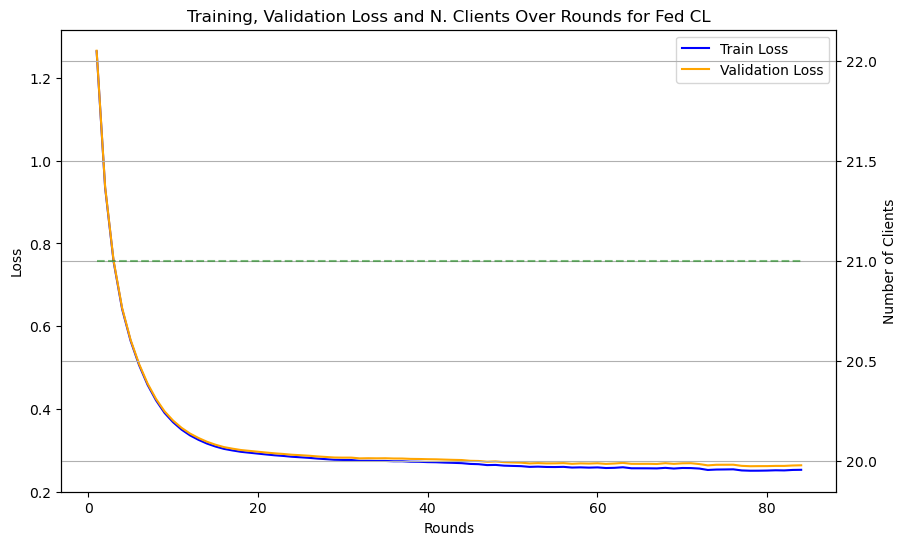

In [16]:
# plot the history
with open('model_weights/HAR_Fed_CL/results.json', 'r') as json_file:
    data = json.load(json_file)
plot_history(data["round"], data["train_loss"], data["val_loss"], data["n_clients"], "Fed CL")

In [19]:
f1s = []
f1s_2shots = []
for i in range(len(clients)):
    # load the client dataset and apply preprocessing 
    # (MinMaxScaler and get only the first 144 features with the highest variance)
    client = clients[i]
    dataset = har.get_dataset(client)
    CH_model = har.create_model_CH(dense_size=128)
    train_images, train_labels, test_images, test_labels = dataset
    train_images, test_images = har.preprocessing(train_images, test_images)
    
    # load the Fed trained model and test it
    CH_model.load_weights("model_weights\HAR_Fed_CL\model.h5")
    predicts = CH_model.predict(test_images, batch_size=128, verbose=0)
    f1 = f1_score(test_labels.argmax(1), predicts.argmax(1), average='micro')
    f1s.append(f1)
    
    # 2-shots learning phase (freeze first layers and train)
    CH_model.get_layer("1_Dense").trainable = False
    CH_model.get_layer("2_Dense").trainable = False
    train_CH_shots(steps=51, shots=2)
    predicts = CH_model.predict(test_images, batch_size=128, verbose=0)
    f1_shots = f1_score(test_labels.argmax(1), predicts.argmax(1), average='micro')
    f1s_2shots.append(f1_shots)
    print("Client: {0}, n. samples: {1}, micro f1: {2}, micro f1 after 2-shots: {3}".format(client, len(train_images), 
                                                                                            round(f1,2),round(f1_shots,2)))

Client: 1, n. samples: 208, micro f1: 0.99, micro f1 after 2-shots: 1.0
Client: 3, n. samples: 204, micro f1: 0.96, micro f1 after 2-shots: 0.96
Client: 5, n. samples: 181, micro f1: 0.85, micro f1 after 2-shots: 0.91
Client: 6, n. samples: 195, micro f1: 0.8, micro f1 after 2-shots: 0.9
Client: 7, n. samples: 184, micro f1: 0.94, micro f1 after 2-shots: 0.95
Client: 8, n. samples: 168, micro f1: 0.91, micro f1 after 2-shots: 0.96
Client: 11, n. samples: 189, micro f1: 1.0, micro f1 after 2-shots: 1.0
Client: 14, n. samples: 193, micro f1: 0.69, micro f1 after 2-shots: 0.94
Client: 15, n. samples: 196, micro f1: 0.96, micro f1 after 2-shots: 0.99
Client: 16, n. samples: 219, micro f1: 0.85, micro f1 after 2-shots: 0.87
Client: 17, n. samples: 220, micro f1: 0.98, micro f1 after 2-shots: 1.0
Client: 19, n. samples: 216, micro f1: 0.86, micro f1 after 2-shots: 0.94
Client: 21, n. samples: 244, micro f1: 0.91, micro f1 after 2-shots: 0.97
Client: 22, n. samples: 192, micro f1: 0.97, micro

In [20]:
print("Mean micro F1 on active clients:", round(sum(f1s)/len(f1s),2))
print("Mean micro F1 on active clients after 2-shots:", round(sum(f1s_2shots)/len(f1s_2shots),2))

Mean micro F1 on active clients: 0.92
Mean micro F1 on active clients after 2-shots: 0.96


In [25]:
f1s = []
f1s_2shots = []
for i in range(len(clients_test)):
    # load the client dataset and apply preprocessing 
    # (MinMaxScaler and get only the first 144 features with the highest variance)
    client = clients_test[i]
    dataset = har_test.get_dataset(client)
    CH_model = har.create_model_CH(dense_size=128)
    train_images, train_labels, test_images, test_labels = dataset
    train_images, test_images = har.preprocessing(train_images, test_images)
    
    # load the Fed trained model and test it
    CH_model.load_weights("model_weights\HAR_Fed_CL\model.h5")
    predicts = CH_model.predict(test_images, batch_size=128, verbose=0)
    f1 = f1_score(test_labels.argmax(1), predicts.argmax(1), average='micro')
    f1s.append(f1)
    
    # 2-shots learning phase (freeze first layers and train)
    previous_loss = float('inf')
    CH_model.get_layer("1_Dense").trainable = False
    CH_model.get_layer("2_Dense").trainable = False
    train_CH_shots(steps=51, shots=2)
    predicts = CH_model.predict(test_images, batch_size=128, verbose=0)
    f1_shots = f1_score(test_labels.argmax(1), predicts.argmax(1), average='micro')
    f1s_2shots.append(f1_shots)
    print("Client: {0}, n. samples: {1}, micro f1: {2}, micro f1 after 2-shots: {3}".format(client, len(train_images), 
                                                                                            round(f1,2),round(f1_shots,2)))

Client: 2, n. samples: 181, micro f1: 0.97, micro f1 after 2-shots: 0.98
Client: 4, n. samples: 190, micro f1: 0.91, micro f1 after 2-shots: 0.93
Client: 9, n. samples: 172, micro f1: 0.84, micro f1 after 2-shots: 0.84
Client: 10, n. samples: 176, micro f1: 0.75, micro f1 after 2-shots: 0.84
Client: 12, n. samples: 192, micro f1: 0.9, micro f1 after 2-shots: 0.98
Client: 13, n. samples: 196, micro f1: 0.95, micro f1 after 2-shots: 0.98
Client: 18, n. samples: 218, micro f1: 0.88, micro f1 after 2-shots: 0.9
Client: 20, n. samples: 212, micro f1: 0.92, micro f1 after 2-shots: 0.96
Client: 24, n. samples: 228, micro f1: 0.99, micro f1 after 2-shots: 0.99


In [26]:
print("Mean micro F1 on unseen clients:", round(sum(f1s)/len(f1s),2))
print("Mean micro F1 on unseen clients after 2-shots:", round(sum(f1s_2shots)/len(f1s_2shots),2))

Mean micro F1 on unseen clients: 0.9
Mean micro F1 on unseen clients after 2-shots: 0.93


## Fed CI-VAE

In [23]:
har.create_model(latent_dim=3, dense_size=64).summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_363 (InputLayer)         [(None, 12, 12, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 3),          11558       ['input_363[0][0]']              
                                 (None, 3),                                                       
                                 (None, 3)]                                                       
                                                                                                  
 decoder (Functional)           (None, 12, 12, 1)    12080       ['encoder[0][2]']                
                                                                                                

<IPython.core.display.Javascript object>


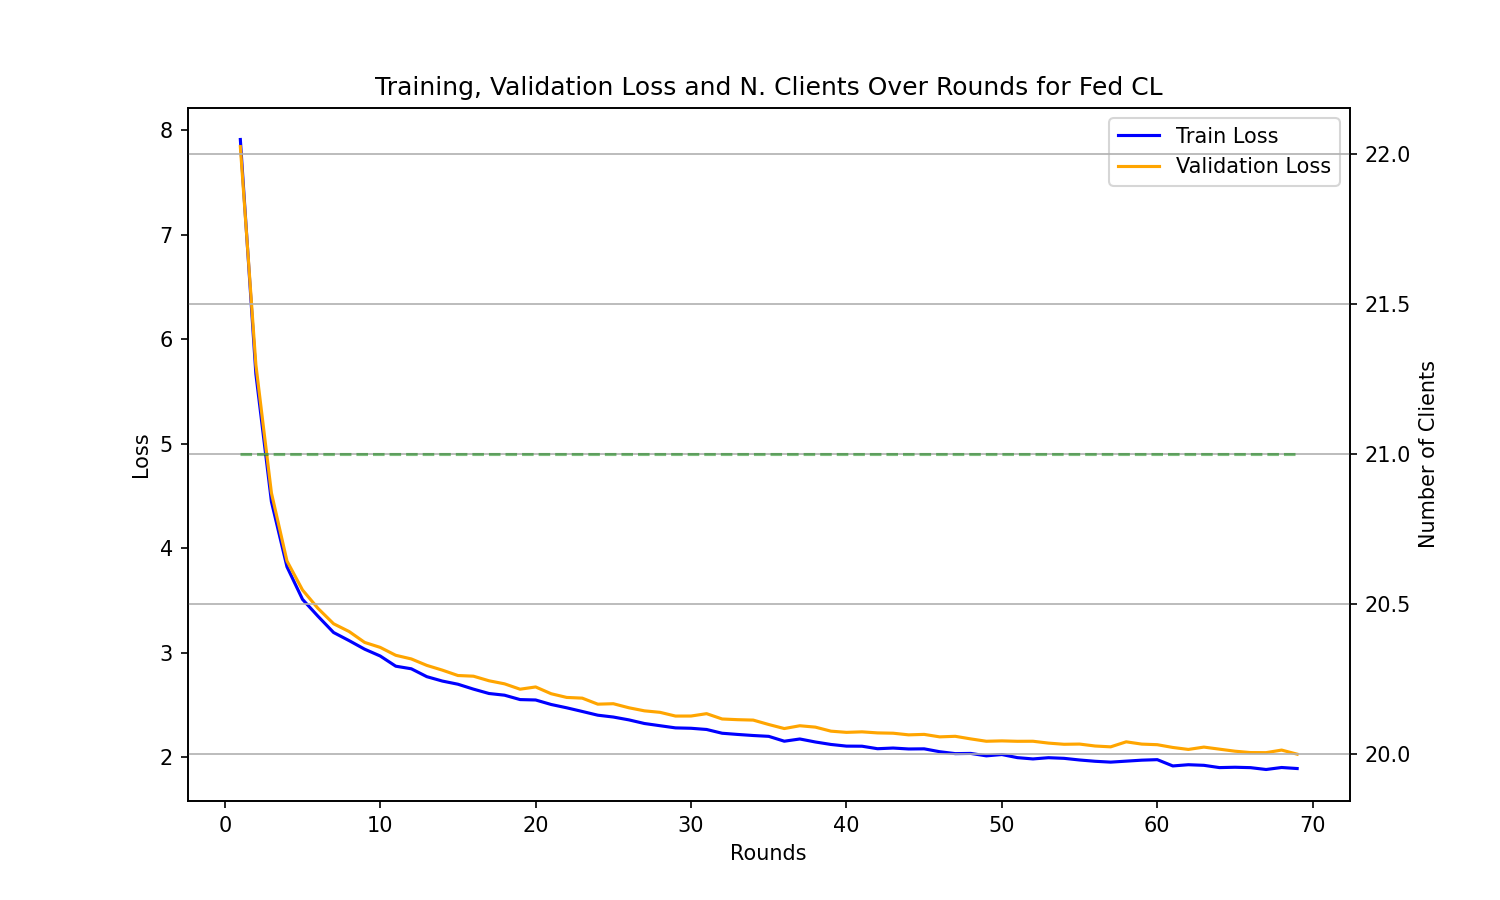

In [82]:
# plot the history
with open('model_weights/HAR_Fed_CI-VAE/results.json', 'r') as json_file:
    data = json.load(json_file)
plot_history(data["round"], data["train_loss"], data["val_loss"], data["n_clients"], "Fed CL")

In [32]:
f1s = []
f1s_2shots = []
for i in range(len(clients)):
    # load the client dataset and apply preprocessing 
    # (MinMaxScaler and get only the first 144 features with the highest variance)
    client = clients[i]
    dataset = har.get_dataset(client)
    CI_VAE = har.create_model(latent_dim=3, dense_size=64)
    train_images, train_labels, test_images, test_labels = dataset
    train_images, test_images = har.preprocessing(train_images, test_images)
    
    # load the Fed trained model and test it
    CI_VAE.load_weights("model_weights\HAR_Fed_CI-VAE\model.h5")
    CI_VAE.get_layer("encoder").load_weights("model_weights\HAR_Fed_CI-VAE\{0}_encoder_weights.h5".format(client))
    CI_VAE.get_layer("decoder").load_weights("model_weights\HAR_Fed_CI-VAE\{0}_decoder_weights.h5".format(client))
    predicts = CI_VAE.predict(test_images, batch_size=128, verbose=0)
    f1 = f1_score(test_labels.argmax(1), predicts[1].argmax(1), average='micro')
    f1s.append(f1)
    
    print("Client: {0}, n. samples: {1}, micro f1: {2}".format(client, len(train_images), round(f1,2)))

Client: 1, n. samples: 208, micro f1: 0.99
Client: 3, n. samples: 204, micro f1: 0.91
Client: 5, n. samples: 181, micro f1: 0.95
Client: 6, n. samples: 195, micro f1: 0.93
Client: 7, n. samples: 184, micro f1: 0.97
Client: 8, n. samples: 168, micro f1: 0.95
Client: 11, n. samples: 189, micro f1: 0.98
Client: 14, n. samples: 193, micro f1: 0.95
Client: 15, n. samples: 196, micro f1: 0.99
Client: 16, n. samples: 219, micro f1: 0.95
Client: 17, n. samples: 220, micro f1: 0.99
Client: 19, n. samples: 216, micro f1: 0.99
Client: 21, n. samples: 244, micro f1: 0.98
Client: 22, n. samples: 192, micro f1: 0.98
Client: 23, n. samples: 223, micro f1: 0.96
Client: 25, n. samples: 245, micro f1: 0.99
Client: 26, n. samples: 235, micro f1: 0.98
Client: 27, n. samples: 225, micro f1: 0.96
Client: 28, n. samples: 229, micro f1: 0.97
Client: 29, n. samples: 206, micro f1: 0.99
Client: 30, n. samples: 229, micro f1: 0.99


In [33]:
print("Mean micro F1 on active clients:", round(sum(f1s)/len(f1s),2))

Mean micro F1 on active clients: 0.97


<IPython.core.display.Javascript object>


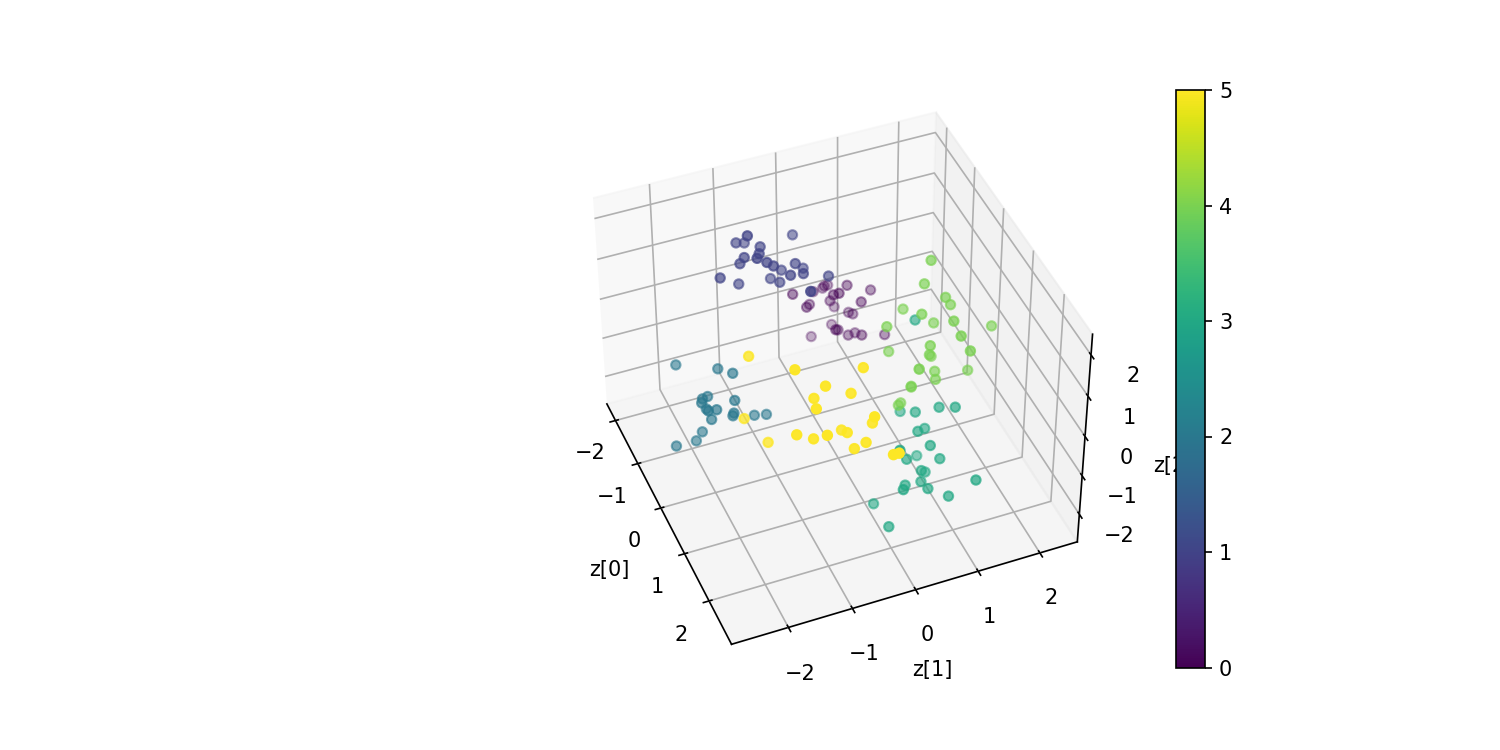

In [81]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
client = 14
dataset = har.get_dataset(client)
CI_VAE = har.create_model(latent_dim=3, dense_size=64)
train_images, train_labels, test_images, test_labels = dataset
train_images, test_images = har.preprocessing(train_images, test_images)
CI_VAE.load_weights("model_weights\HAR_Fed_CI-VAE\model.h5")
CI_VAE.get_layer("encoder").load_weights("model_weights\HAR_Fed_CI-VAE\{0}_encoder_weights.h5".format(client))
CI_VAE.get_layer("decoder").load_weights("model_weights\HAR_Fed_CI-VAE\{0}_decoder_weights.h5".format(client))

%matplotlib notebook
plot_label_clusters_3d(test_images, test_labels.argmax(1))

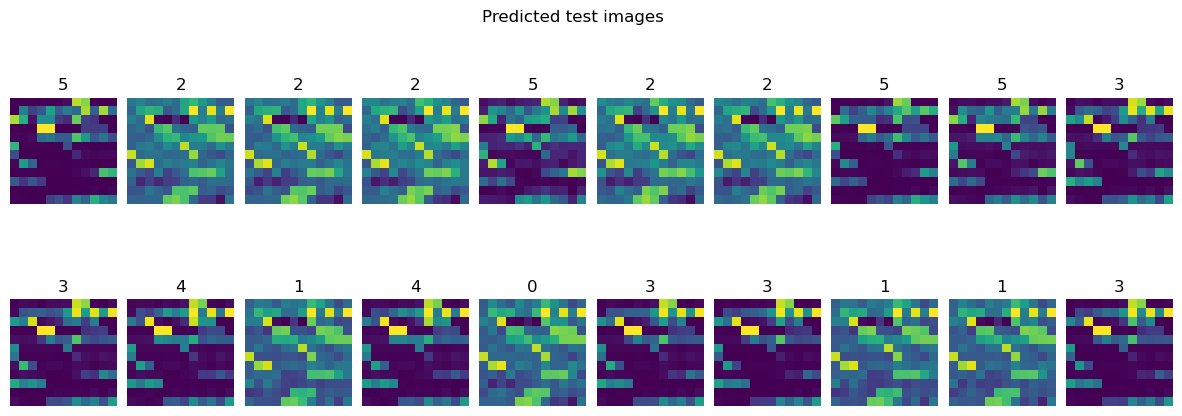

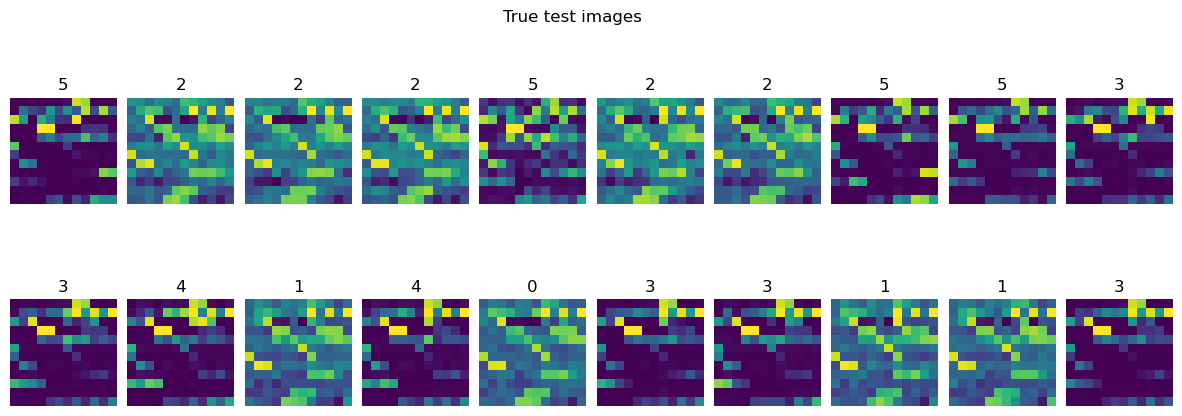

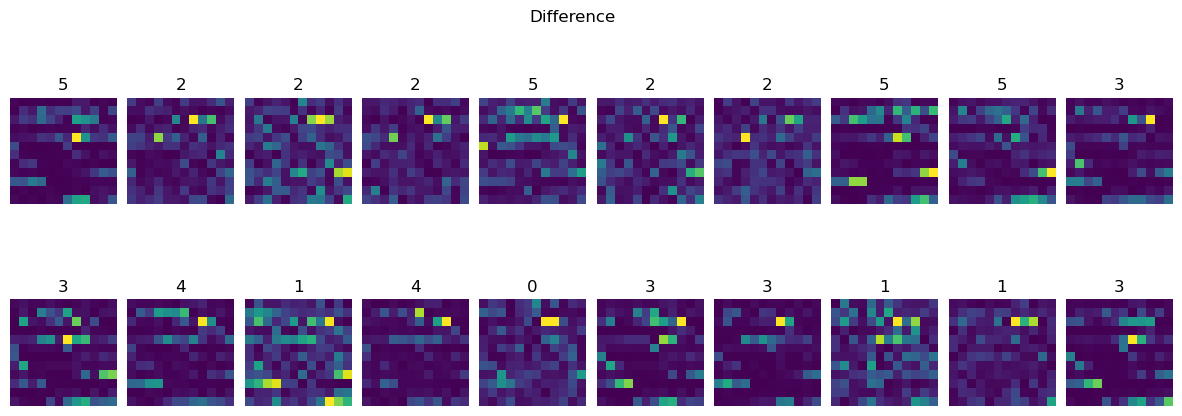

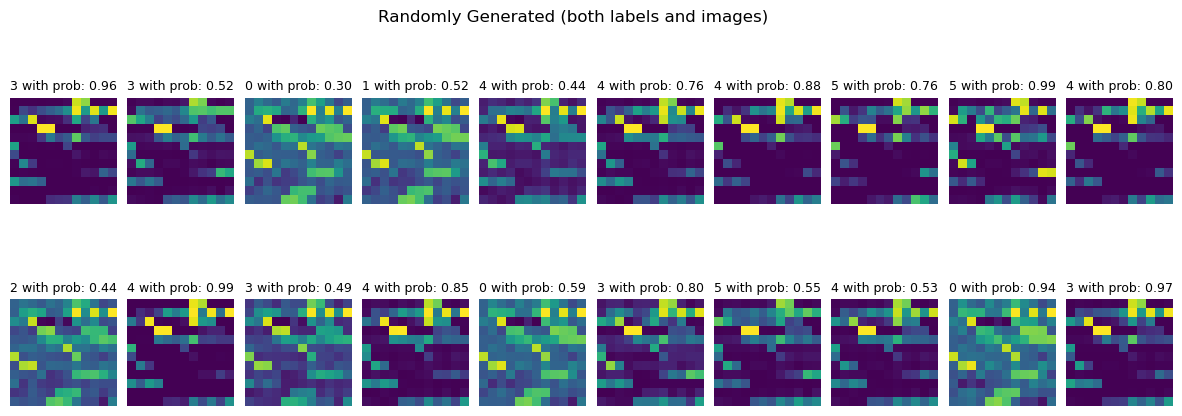

In [80]:
%matplotlib inline
predicts = CI_VAE.predict(test_images)[0]
plot_images(predicts, test_labels.argmax(1), "Predicted test images")
plot_images(test_images, test_labels.argmax(1), "True test images")
plot_images(abs(predicts-test_images), test_labels.argmax(1), "Difference")

num_samples = 20
latent_samples = np.random.normal(size=(num_samples, 3))
decoded_images = CI_VAE.get_layer('decoder')(latent_samples, training=False).numpy()
output_labels = CI_VAE.get_layer('class_model')(latent_samples, training=False).numpy()
plot_images(decoded_images, output_labels.argmax(1), "Randomly Generated (both labels and images)", 
            probs=output_labels.max(1))

In [78]:
f1s = []
f1s_2shots = []
for i in range(len(clients_test)):
    # load the client dataset and apply preprocessing 
    # (MinMaxScaler and get only the first 144 features with the highest variance)
    client = clients_test[i]
    dataset = har_test.get_dataset(client)
    CI_VAE = har.create_model(latent_dim=3, dense_size=64)
    train_images, train_labels, test_images, test_labels = dataset
    train_images, test_images = har.preprocessing(train_images, test_images)
    
    # load the Fed trained model and test it
    CI_VAE.load_weights("model_weights\HAR_Fed_CI-VAE\model.h5")
    predicts = CI_VAE.predict(test_images, batch_size=128, verbose=0)
    f1 = f1_score(test_labels.argmax(1), predicts[1].argmax(1), average='micro')
    f1s.append(f1)
    
    # 2-shots learning phase (freeze first layers and train)
    train_shots()
    predicts = CI_VAE.predict(test_images, batch_size=128, verbose=0)
    f1_shots = f1_score(test_labels.argmax(1), predicts[1].argmax(1), average='micro')
    f1s_2shots.append(f1_shots)
    print("Client: {0}, n. samples: {1}, micro f1: {2}, micro f1 after 2-shots: {3}".format(client, len(train_images), 
                                                                                            round(f1,2),round(f1_shots,2)))

Client: 2, n. samples: 181, micro f1: 0.76, micro f1 after 2-shots: 0.93
Client: 4, n. samples: 190, micro f1: 0.77, micro f1 after 2-shots: 0.81
Client: 9, n. samples: 172, micro f1: 0.6, micro f1 after 2-shots: 0.78
Client: 10, n. samples: 176, micro f1: 0.65, micro f1 after 2-shots: 0.85
Client: 12, n. samples: 192, micro f1: 0.75, micro f1 after 2-shots: 0.8
Client: 13, n. samples: 196, micro f1: 0.92, micro f1 after 2-shots: 0.95
Client: 18, n. samples: 218, micro f1: 0.8, micro f1 after 2-shots: 0.89
Client: 20, n. samples: 212, micro f1: 0.74, micro f1 after 2-shots: 0.78
Client: 24, n. samples: 228, micro f1: 0.78, micro f1 after 2-shots: 0.89


In [79]:
print("Mean micro F1 on unseen clients:", round(sum(f1s)/len(f1s),2))
print("Mean micro F1 on unseen clients after 2-shots:", round(sum(f1s_2shots)/len(f1s_2shots),2))

Mean micro F1 on unseen clients: 0.75
Mean micro F1 on unseen clients after 2-shots: 0.85


## FedRep CI-VAE

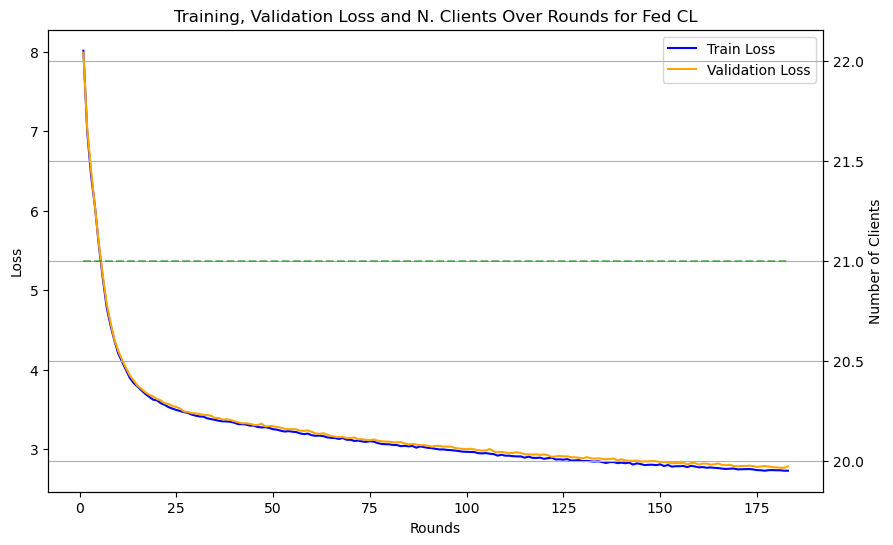

In [166]:
# plot the history
with open('model_weights/HAR_FedRep/results.json', 'r') as json_file:
    data = json.load(json_file)
plot_history(data["round"], data["train_loss"], data["val_loss"], data["n_clients"], "Fed CL")

In [112]:
f1s = []
f1s_2shots = []
for i in range(len(clients)):
    # load the client dataset and apply preprocessing 
    # (MinMaxScaler and get only the first 144 features with the highest variance)
    client = clients[i]
    dataset = har.get_dataset(client)
    CI_VAE = har.create_model(latent_dim=3, dense_size=64)
    train_images, train_labels, test_images, test_labels = dataset
    train_images, test_images = har.preprocessing(train_images, test_images)
    
    # load the Fed trained model and test it
    CI_VAE.load_weights("model_weights\HAR_FedRep\model.h5")
    predicts = CI_VAE.predict(test_images, batch_size=128, verbose=0)
    f1 = f1_score(test_labels.argmax(1), predicts[1].argmax(1), average='micro')
    f1s.append(f1)
    
    # 2-shots learning phase (freeze first layers and train)
    train_shots()
    predicts = CI_VAE.predict(test_images, batch_size=128, verbose=0)
    f1_shots = f1_score(test_labels.argmax(1), predicts[1].argmax(1), average='micro')
    f1s_2shots.append(f1_shots)
    
    print("Client: {0}, n. samples: {1}, micro f1: {2}, micro f1 after 2-shots: {3}".format(client, len(train_images), 
                                                                                            round(f1,2),round(f1_shots,2)))

Client: 1, n. samples: 208, micro f1: 0.97, micro f1 after 2-shots: 0.96
Client: 3, n. samples: 204, micro f1: 0.91, micro f1 after 2-shots: 0.91
Client: 5, n. samples: 181, micro f1: 0.83, micro f1 after 2-shots: 0.91
Client: 6, n. samples: 195, micro f1: 0.79, micro f1 after 2-shots: 0.87
Client: 7, n. samples: 184, micro f1: 0.93, micro f1 after 2-shots: 0.89
Client: 8, n. samples: 168, micro f1: 0.87, micro f1 after 2-shots: 0.91
Client: 11, n. samples: 189, micro f1: 0.99, micro f1 after 2-shots: 0.97
Client: 14, n. samples: 193, micro f1: 0.72, micro f1 after 2-shots: 0.88
Client: 15, n. samples: 196, micro f1: 0.94, micro f1 after 2-shots: 0.95
Client: 16, n. samples: 219, micro f1: 0.84, micro f1 after 2-shots: 0.82
Client: 17, n. samples: 220, micro f1: 0.96, micro f1 after 2-shots: 0.94
Client: 19, n. samples: 216, micro f1: 0.85, micro f1 after 2-shots: 0.9
Client: 21, n. samples: 244, micro f1: 0.93, micro f1 after 2-shots: 0.95
Client: 22, n. samples: 192, micro f1: 0.94, 

In [113]:
print("Mean micro F1 on active clients:", round(sum(f1s)/len(f1s),2))
print("Mean micro F1 on active clients after 2-shots:", round(sum(f1s_2shots)/len(f1s_2shots),2))

Mean micro F1 on active clients: 0.9
Mean micro F1 on active clients after 2-shots: 0.92


In [163]:
f1s = []
f1s_2shots = []
for i in range(len(clients_test)):
    # load the client dataset and apply preprocessing 
    # (MinMaxScaler and get only the first 144 features with the highest variance)
    client = clients_test[i]
    dataset = har_test.get_dataset(client)
    CI_VAE = har.create_model(latent_dim=3, dense_size=64)
    train_images, train_labels, test_images, test_labels = dataset
    train_images, test_images = har.preprocessing(train_images, test_images)
    
    # load the Fed trained model and test it
    CI_VAE.load_weights("model_weights\HAR_FedRep\model.h5")
    predicts = CI_VAE.predict(test_images, batch_size=128, verbose=0)
    f1 = f1_score(test_labels.argmax(1), predicts[1].argmax(1), average='micro')
    f1s.append(f1)
    
    # 2-shots learning phase (freeze first layers and train)
    if len(predicts[1].max(1)[predicts[1].max(1)<0.4]) > 0: # 0.40 and 10 as thresholds to be tune
        train_shots()
        predicts = CI_VAE.predict(test_images, batch_size=128, verbose=0)
        f1_shots = f1_score(test_labels.argmax(1), predicts[1].argmax(1), average='micro')
        f1s_2shots.append(f1_shots)
    else: 
        f1s_2shots.append(f1)
        f1_shots = f1
    print("Client: {0}, n. samples: {1}, micro f1: {2}, micro f1 after 2-shots: {3}".format(client, len(train_images), 
                                                                                            round(f1,2),round(f1_shots,2)))

Client: 2, n. samples: 181, micro f1: 0.98, micro f1 after 2-shots: 0.98
Client: 4, n. samples: 190, micro f1: 0.86, micro f1 after 2-shots: 0.89
Client: 9, n. samples: 172, micro f1: 0.81, micro f1 after 2-shots: 0.83
Client: 10, n. samples: 176, micro f1: 0.69, micro f1 after 2-shots: 0.86
Client: 12, n. samples: 192, micro f1: 0.88, micro f1 after 2-shots: 0.91
Client: 13, n. samples: 196, micro f1: 0.95, micro f1 after 2-shots: 0.95
Client: 18, n. samples: 218, micro f1: 0.86, micro f1 after 2-shots: 0.95
Client: 20, n. samples: 212, micro f1: 0.91, micro f1 after 2-shots: 0.91
Client: 24, n. samples: 228, micro f1: 0.98, micro f1 after 2-shots: 0.98


In [164]:
print("Mean micro F1 on unseen clients:", round(sum(f1s)/len(f1s),2))
print("Mean micro F1 on unseen clients after 2-shots:", round(sum(f1s_2shots)/len(f1s_2shots),2))

Mean micro F1 on unseen clients: 0.88
Mean micro F1 on unseen clients after 2-shots: 0.92
